In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from scipy.stats import norm
import pandas as pd
from datetime import datetime
from polygon import RESTClient
from datetime import datetime
from scipy.optimize import brentq
import math
from sklearn.preprocessing import MinMaxScaler

## Prepare data

### implement BS-model, and invers BS-model to calculate imp_vol

In [2]:
def black_scholes_call(S, K, T, r, sigma):
    if sigma == 0:
        return max(S - K * np.exp(-r * T), 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility_call(S, K, T, r, option_price, sigma_low=1e-6, sigma_high=5.0):
    def objective(sigma):
        return black_scholes_call(S, K, T, r, sigma) - option_price
    
    try:
        return brentq(objective, sigma_low, sigma_high)
    except ValueError:
        # If no root found, return NaN or handle appropriately
        return np.nan

# Example usage function
def compute_implied_vol(ttm_days, S, K, option_price):
    r = 0.043  # Risk-free rate 4.3%
    T = ttm_days / 365.0  # Convert days to years (assuming 365-day year)
    return implied_volatility_call(S, K, T, r, option_price)

### Construct Data set

In [74]:
option_symbol = "AAPL251219C00240000"

In [75]:
underlying = option_symbol[:4]
exp_str = option_symbol[4:10]
option_type = option_symbol[10]
strike_raw = option_symbol[11:]

# Parse expiration date
exp_date = datetime.strptime(exp_str, "%y%m%d").date()
strike_price = int(strike_raw) / 1000.0

# Initialize client with your API key
client = RESTClient(api_key="XN1r3nHQ1Rb3SsbqdwDI72dE35vJkCzP")

# Option ticker (Polygon format: O:{symbol})
option_ticker = "O:"+option_symbol

# Date range: Approximate listing (2024-09-01) to today (2025-09-25)
from_date = "2024-09-01"
to_date = "2025-09-25"

# Fetch daily aggregates (OHLCV bars)
aggs = []
for a in client.list_aggs(
    ticker=option_ticker,
    multiplier=1,
    timespan="day",
    from_=from_date,
    to=to_date,
    limit=50000,  # Max results per call
    sort="asc"
):
    aggs.append(a)
    
stock_aggs = []
for a in client.list_aggs(
    ticker=underlying,
    multiplier=1,
    timespan="day",
    from_=from_date,
    to=to_date,
    limit=50000,
    sort="asc"
):
    stock_aggs.append(a)

# Create a dictionary to map trading dates to stock prices
stock_prices = {}
for stock_agg in stock_aggs:
    stock_date = datetime.fromtimestamp(stock_agg.timestamp / 1000).date()
    stock_prices[stock_date] = stock_agg.close
    
# Create lists to store TTM, close prices, and stock prices
ttm_days = []
option_prices = []
stock_prices_list = []
trading_dates = []
imp_vol_list = []

# Calculate TTM for each trading date and get corresponding stock price
for agg in aggs:
    trading_date = datetime.fromtimestamp(agg.timestamp / 1000).date()
    ttm = (exp_date - trading_date).days
    stock_price = stock_prices.get(trading_date, None)  # Get stock price for this date
    
    ttm_days.append(ttm)
    option_prices.append(agg.close)
    stock_prices_list.append(stock_price)
    trading_dates.append(trading_date)
    imp_vol_list.append(compute_implied_vol(ttm, stock_price, strike_price, agg.close))

# Create the enhanced dataframe with strike price
df_ttm_close_stock = pd.DataFrame({
    'Trading_Date': trading_dates,
    'TTM_Days': ttm_days,
    'Stock_Price': stock_prices_list,
    'Strike_Price': strike_price,
    'implied_vol': imp_vol_list,
    'Option_Price': option_prices,
})
df_ttm_close_stock = df_ttm_close_stock.dropna()

### Detail of Data set

In [76]:
print("shape:", df_ttm_close_stock.shape)
df_ttm_close_stock

shape: (263, 6)


,Trading_Date,TTM_Days,Stock_Price,Strike_Price,implied_vol,Option_Price
0,2024-09-03,472,222.77,240.0,0.243628,22.71
1,2024-09-04,471,220.85,240.0,0.244414,21.75
2,2024-09-05,470,222.38,240.0,0.246710,22.74
3,2024-09-06,469,220.82,240.0,0.246810,21.90
4,2024-09-09,466,220.91,240.0,0.230885,20.25
...,...,...,...,...,...,...
258,2025-09-18,92,237.88,240.0,0.239964,11.65
259,2025-09-19,91,245.50,240.0,0.239548,15.99
260,2025-09-22,88,256.08,240.0,0.261871,24.03
261,2025-09-23,87,254.43,240.0,0.256096,22.50


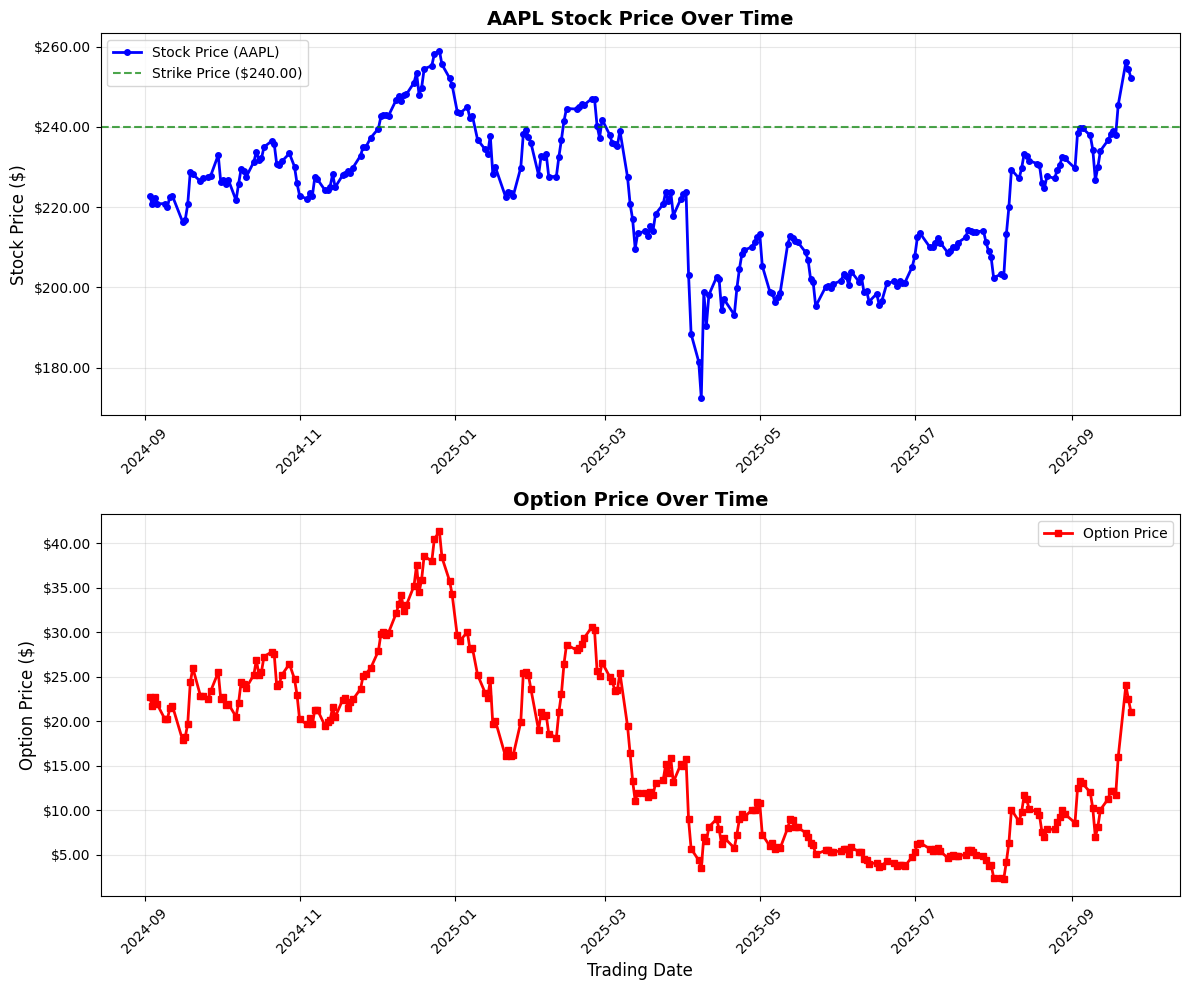

In [77]:
import matplotlib.pyplot as plt

# Create subplots with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Subplot 1: Stock Price
ax1.plot(df_ttm_close_stock['Trading_Date'], df_ttm_close_stock['Stock_Price'], 
         color='blue', linewidth=2, label='Stock Price (AAPL)', marker='o', markersize=4)
ax1.axhline(y=strike_price, color='green', linestyle='--', alpha=0.7, label=f'Strike Price (${strike_price:.2f})')
ax1.set_title('AAPL Stock Price Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Stock Price ($)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

# Subplot 2: Option Price
ax2.plot(df_ttm_close_stock['Trading_Date'], df_ttm_close_stock['Option_Price'], 
         color='red', linewidth=2, label='Option Price', marker='s', markersize=4)
ax2.set_title('Option Price Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Trading Date', fontsize=12)
ax2.set_ylabel('Option Price ($)', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


## Transformer Model Construction

In [ ]:
# Load your data (already in memory as df_ttm_close_stock)
df = df_ttm_close_stock.copy()

# Define features and target
# features = ['TTM_Days', 'Stock_Price', 'Strike_Price', 'implied_vol']
features = ['TTM_Days', 'Stock_Price', 'Strike_Price', 'Option_Price']
target = 'Option_Price'

X = df[features].values
y = df[target].values

# Normalize to [0, 1]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

train_size = int(0.8*X.shape[0])
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [97]:
def create_dataset(X, y, Tx=5, Ty=1):
    Xs, ys = [], []
    for i in range(len(X) - Tx - Ty + 1):
        Xs.append(X[i:i+Tx])
        ys.append(y[i+Tx:i+Tx+Ty])
    return np.array(Xs), np.array(ys)

Tx, Ty = 5, 1
X_train_seq, y_train_seq = create_dataset(X_train, y_train, Tx, Ty)
X_test_seq, y_test_seq = create_dataset(X_test, y_test, Tx, Ty)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train_seq)  # (N, Tx, 4)
y_train_t = torch.FloatTensor(y_train_seq)  # (N, Ty)
X_test_t = torch.FloatTensor(X_test_seq)
y_test_t = torch.FloatTensor(y_test_seq)

In [ ]:
class TimeSeriesTransformer(nn.Module):
    """
    A Transformer-based model for time series forecasting, specifically designed for option pricing.
    
    This model uses the encoder-decoder architecture where:
    - Encoder processes historical time series data (past option prices, stock prices, etc.)
    - Decoder generates future predictions (next option price)
    """
    
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=2, dim_feedforward=64, dropout=0.1, Ty=1):
        super().__init__()
        
        # Store key parameters
        self.input_dim = input_dim  # Number of input features (e.g., TTM, Stock_Price, Strike_Price, implied_vol)
        self.d_model = d_model      # Hidden dimension size (32) - must be divisible by nhead
        self.Ty = Ty               # Number of future time steps to predict (1 for next-day prediction)
        
        # Input projection layer: Maps input features to transformer's hidden dimension
        # Converts from input_dim (4 features) to d_model (32 dimensions)
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Positional encoding: Adds position information to sequences
        # Essential because transformers don't inherently understand sequence order
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Core Transformer model with encoder-decoder architecture
        self.transformer = nn.Transformer(
            d_model=d_model,                    # Hidden dimension (32)
            nhead=nhead,                        # Number of attention heads (4)
            num_encoder_layers=num_layers,      # Number of encoder layers (2)
            num_decoder_layers=num_layers,     # Number of decoder layers (2)
            dim_feedforward=dim_feedforward,   # Feed-forward network dimension (64)
            dropout=dropout,                   # Dropout rate for regularization (0.1)
            batch_first=False                  # Input format: (sequence, batch, features)
        )
        
        # Output projection: Maps transformer output back to prediction dimension
        # Converts from d_model (32) to Ty (1) for single-step prediction
        self.fc_out = nn.Linear(d_model, Ty)
        
    def forward(self, src, tgt):
        """
        Forward pass of the transformer model.
        
        Args:
            src: Source sequence (Tx, B, input_dim) - Historical data
            tgt: Target sequence (Ty, B, input_dim) - Usually zeros for generative decoding
            
        Returns:
            output: Predicted values (Ty, B) - Future predictions
        """
        
        # Step 1: Embed source sequence (historical data)
        # Convert input features to transformer's hidden dimension
        src = self.embedding(src) * np.sqrt(self.d_model)  # Scale by sqrt(d_model) for stability
        src = self.pos_encoder(src)  # Add positional information
        
        # Step 2: Embed target sequence (future predictions)
        # For generative decoding, tgt is usually zeros or previous predictions
        tgt = self.embedding(tgt) * np.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)
        
        # Step 3: Create causal mask for decoder
        # Prevents decoder from "looking ahead" to future positions during training
        # This ensures autoregressive generation (predicting one step at a time)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(0)).to(src.device)
        
        # Step 4: Run transformer encoder-decoder
        # Encoder processes historical data, decoder generates future predictions
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        
        # Step 5: Project to final output dimension
        # Convert transformer output to actual predictions
        output = self.fc_out(output)  # (Ty, B, Ty) → (Ty, B, 1)
        return output.squeeze(-1)      # (Ty, B) - Remove last dimension for final predictions

class PositionalEncoding(nn.Module):
    """
    Positional Encoding for Transformer models.
    
    Since transformers don't have inherent understanding of sequence position,
    we add positional information using sinusoidal functions. This allows the model
    to understand the temporal order of the input sequence.
    
    Uses sine and cosine functions of different frequencies to encode position information.
    """
    
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)  # Initialize with zeros
        
        # Create position indices (0, 1, 2, ..., max_len-1)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Calculate division term for sinusoidal functions
        # Creates different frequencies for different dimensions
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        # Apply sinusoidal encoding:
        # Even indices (0, 2, 4, ...) use sine function
        pe[:, 0::2] = torch.sin(position * div_term)
        # Odd indices (1, 3, 5, ...) use cosine function
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Reshape for transformer input format: (max_len, 1, d_model)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        # Register as buffer (not a parameter, but part of model state)
        # This ensures pe is moved to GPU/CPU with the model
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Add positional encoding to input sequence.
        
        Args:
            x: Input tensor (seq_len, batch_size, d_model)
            
        Returns:
            x + positional_encoding: Input with added positional information
        """
        # Add positional encoding to input
        # Only use positions up to the actual sequence length
        x = x + self.pe[:x.size(0), :]
        
        # Apply dropout for regularization
        return self.dropout(x)

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)


model = TimeSeriesTransformer(
    input_dim=len(features),
    d_model=32,
    nhead=4,
    num_layers=2,
    dim_feedforward=64,
    dropout=0.1,
    Ty=Ty
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Prepare data: (seq_len, batch, features)
X_train_t = X_train_t.permute(1, 0, 2).to(device)  # (Tx, N, 4)
y_train_t = y_train_t.permute(1, 0).to(device)     # (Ty, N)

# Dummy decoder input: use last known feature values or zeros
# Here we use zeros for simplicity (generative style)
B = X_train_t.shape[1]
decoder_input = torch.zeros(Ty, B, len(features)).to(device)

# Training
epochs = 50000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(X_train_t, decoder_input)  # (Ty, B)
    loss = criterion(output, y_train_t)
    
    loss.backward()
    optimizer.step()
    if loss.item() < 0.0001:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")
        break
    
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

using device: cuda
Epoch 500, Loss: 0.026317
Epoch 1000, Loss: 0.015709
Epoch 1500, Loss: 0.014030
Epoch 2000, Loss: 0.009194
Epoch 2500, Loss: 0.006198
Epoch 3000, Loss: 0.005867
Epoch 3500, Loss: 0.005540
Epoch 4000, Loss: 0.006087
Epoch 4500, Loss: 0.005009
Epoch 5000, Loss: 0.004263
Epoch 5500, Loss: 0.003365
Epoch 6000, Loss: 0.004017
Epoch 6500, Loss: 0.003640
Epoch 7000, Loss: 0.003657
Epoch 7500, Loss: 0.003342
Epoch 8000, Loss: 0.002907
Epoch 8500, Loss: 0.002745
Epoch 9000, Loss: 0.002804
Epoch 9500, Loss: 0.003023
Epoch 10000, Loss: 0.002832
Epoch 10500, Loss: 0.002492
Epoch 11000, Loss: 0.002619
Epoch 11500, Loss: 0.002312
Epoch 12000, Loss: 0.002206
Epoch 12500, Loss: 0.002425
Epoch 13000, Loss: 0.001810
Epoch 13500, Loss: 0.001874
Epoch 14000, Loss: 0.001755
Epoch 14500, Loss: 0.001680
Epoch 15000, Loss: 0.001543
Epoch 15500, Loss: 0.001629
Epoch 16000, Loss: 0.001426
Epoch 16500, Loss: 0.001270
Epoch 17000, Loss: 0.001628
Epoch 17500, Loss: 0.001101
Epoch 18000, Loss: 0.

In [109]:
model.eval()
with torch.no_grad():
    X_test_t = X_test_t.permute(1, 0, 2).to(device)  # (Tx, N_test, 4)
    B_test = X_test_t.shape[1]
    decoder_input_test = torch.zeros(Ty, B_test, len(features)).to(device)
    
    pred_test = model(X_test_t, decoder_input_test)  # (Ty, N_test)
    pred_test = pred_test.cpu().numpy().T  # (N_test, Ty)
    y_test_true = y_test_seq  # already (N_test, Ty)

# Inverse transform predictions
pred_original = scaler_y.inverse_transform(pred_test)
y_test_original = scaler_y.inverse_transform(y_test_true)

# Metrics
mae = np.mean(np.abs(pred_original - y_test_original))
rmse = np.sqrt(np.mean((pred_original - y_test_original)**2))

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test MAE: 4.0657
Test RMSE: 5.3348


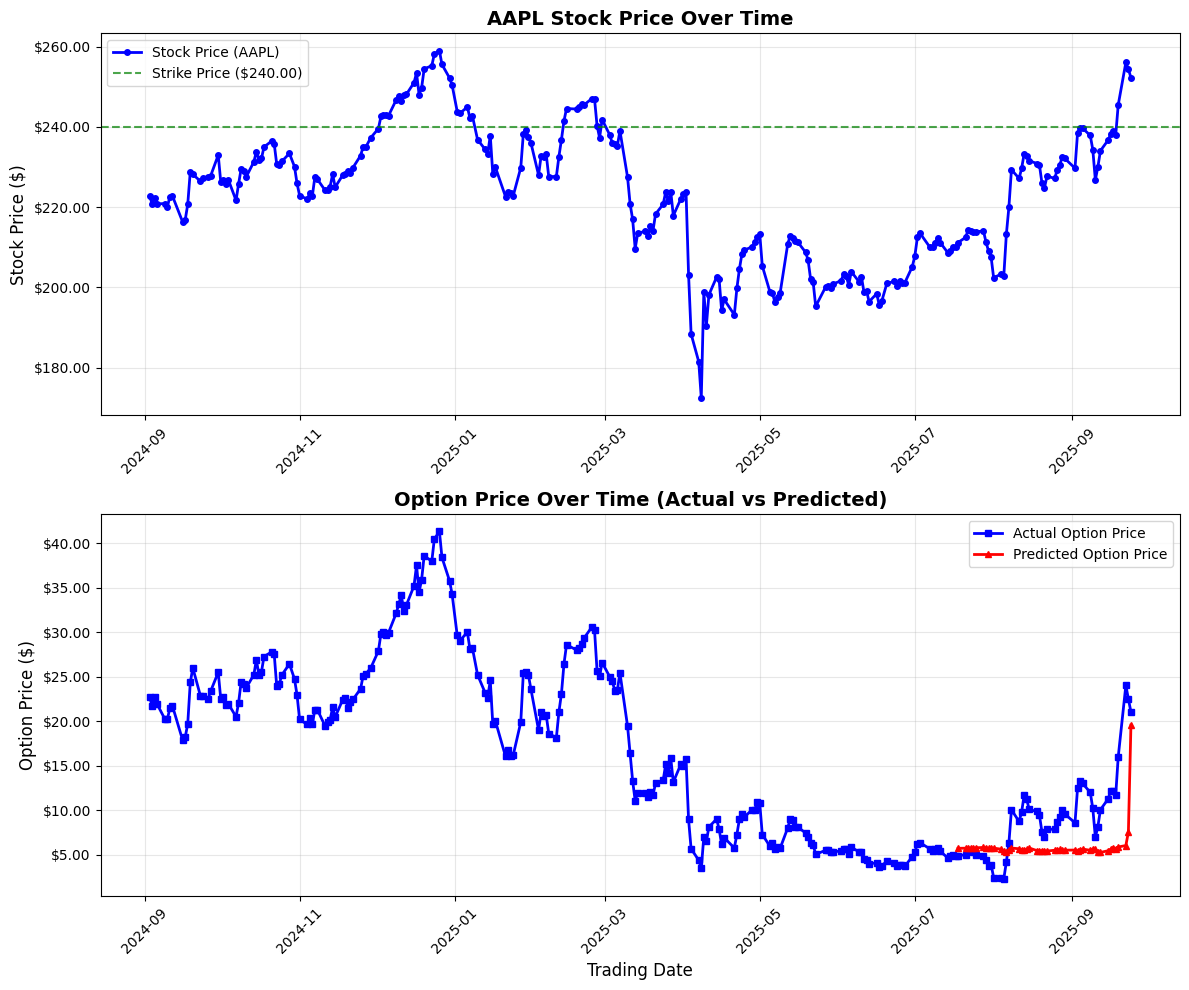

In [110]:
import matplotlib.pyplot as plt

# Create subplots with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Subplot 1: Stock Price
ax1.plot(df_ttm_close_stock['Trading_Date'], df_ttm_close_stock['Stock_Price'], 
         color='blue', linewidth=2, label='Stock Price (AAPL)', marker='o', markersize=4)
ax1.axhline(y=strike_price, color='green', linestyle='--', alpha=0.7, label=f'Strike Price (${strike_price:.2f})')
ax1.set_title('AAPL Stock Price Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Stock Price ($)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

# Subplot 2: Option Price with Predictions
ax2.plot(df_ttm_close_stock['Trading_Date'], df_ttm_close_stock['Option_Price'], 
         color='blue', linewidth=2, label='Actual Option Price', marker='s', markersize=4)

# Plot predicted outcomes in yellow
# Get the test dates (last part of the dataframe)
test_start_idx = len(df_ttm_close_stock) - len(pred_original)
test_dates = df_ttm_close_stock['Trading_Date'].iloc[test_start_idx:test_start_idx + len(pred_original)]

ax2.plot(test_dates, pred_original.flatten(), 
         color='red', linewidth=2, label='Predicted Option Price', marker='^', markersize=4)

ax2.set_title('Option Price Over Time (Actual vs Predicted)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Trading Date', fontsize=12)
ax2.set_ylabel('Option Price ($)', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()
